In [ ]:
# Install PyTorch (if not installed)
!pip install torch torchvision torchaudio
!pip install matplotlib opencv-python-headless


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown "https://drive.google.com/uc?export=download&id=1uTwMIGzbFlwzloGNMpsD1liMVDyZz_qG"
!gdown "https://drive.google.com/uc?export=download&id=1KvszX75UxlJAVG-xtn_6j_EAZp5KUmJ1"
!gdown "https://drive.google.com/uc?export=download&id=1BR3-mVVHJZsK1TYhU2Okxc3SGxx8Pl23"

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1uTwMIGzbFlwzloGNMpsD1liMVDyZz_qG
From (redirected): https://drive.google.com/uc?export=download&id=1uTwMIGzbFlwzloGNMpsD1liMVDyZz_qG&confirm=t&uuid=f793e57c-cb79-49cf-8fab-a771f7a8b197
To: /content/data_2d_h36m_cpn_ft_h36m_dbb.npz
100% 273M/273M [00:03<00:00, 90.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1KvszX75UxlJAVG-xtn_6j_EAZp5KUmJ1
From (redirected): https://drive.google.com/uc?export=download&id=1KvszX75UxlJAVG-xtn_6j_EAZp5KUmJ1&confirm=t&uuid=1743d43e-d7e1-4464-a563-25119ca7378e
To: /content/data_2d_h36m_gt.npz
100% 278M/278M [00:03<00:00, 79.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1BR3-mVVHJZsK1TYhU2Okxc3SGxx8Pl23
From (redirected): https://drive.google.com/uc?export=download&id=1BR3-mVVHJZsK1TYhU2Okxc3SGxx8Pl23&confirm=t&uuid=7dbdc16a-4065-45a1-8326-fd5830c48584
To: /content/data_3d_h36m.npz
100% 183M/183M [00

In [ ]:
import numpy as np

# Load the first .npz file
data_2d = np.load('/content/data_2d_h36m_cpn_ft_h36m_dbb.npz', allow_pickle=True)
# Load the second .npz file
data_3d = np.load('/content/data_3d_h36m.npz', allow_pickle=True)

# Access data from the first file
positions_2d = data_2d['positions_2d']

# Access data from the second file
positions_3d = data_3d['positions_3d']

# Check the contents of the dictionaries inside positions_2d and positions_3d
print("Keys in positions_2d dictionary:", positions_2d.item().keys() if positions_2d.size > 0 else "Empty")
print("Keys in positions_3d dictionary:", positions_3d.item().keys() if positions_3d.size > 0 else "Empty")


Keys in positions_2d dictionary: dict_keys(['S6', 'S7', 'S5', 'S11', 'S1', 'S9', 'S8', 'S2', 'S3', 'S4'])
Keys in positions_3d dictionary: dict_keys(['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'])


In [ ]:
import torch
import numpy as np

class PoseDataset(torch.utils.data.Dataset):
    def __init__(self, data_path_2d, data_path_3d, transform=None):
        self.data_2d = np.load(data_path_2d, allow_pickle=True)
        self.data_3d = np.load(data_path_3d, allow_pickle=True)
        self.transform = transform

        positions_2d = self.data_2d['positions_2d']
        positions_3d = self.data_3d['positions_3d']

        self.positions_2d = positions_2d
        self.positions_3d = positions_3d

        self.subjects = sorted(list(set(self.positions_2d.item().keys()) & set(self.positions_3d.item().keys())))

        self.data_len = 0
        for subject in self.subjects:
            for action in self.positions_2d.item()[subject]:
                self.data_len += len(self.positions_2d.item()[subject][action])

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        current_idx = 0
        for subject in self.subjects:
            for action in self.positions_2d.item()[subject]:
                action_len = len(self.positions_2d.item()[subject][action])
                if current_idx + action_len > idx:
                    data_idx = idx - current_idx
                    keypoints_2d = self.positions_2d.item()[subject][action][data_idx]
                    keypoints_3d = self.positions_3d.item()[subject][action][data_idx]

                    if self.transform:
                        keypoints_2d = self.transform(keypoints_2d)
                        keypoints_3d = self.transform(keypoints_3d)

                    return keypoints_2d, keypoints_3d
                else:
                    current_idx += action_len

    @staticmethod
    def pad_sequence(sequence, max_len, num_keypoints):
        """Pads the sequence to the max length along the time dimension."""
        sequence = torch.tensor(sequence)  # Convert NumPy array to PyTorch tensor

        # Ensure sequence has at least 3 dimensions (add batch and frame dimensions if needed)
        while sequence.ndimension() < 3:
            sequence = sequence.unsqueeze(0)

        padding_size = (max_len - sequence.shape[0], sequence.shape[1], sequence.shape[2])
        padding_tensor = torch.zeros(padding_size, dtype=sequence.dtype)
        return torch.cat([sequence, padding_tensor], dim=0)

    @staticmethod
    def my_collate(batch):
        keypoints_2d = [item[0] for item in batch]
        keypoints_3d = [item[1] for item in batch]

        # Find the maximum sequence length (time steps) in the batch
        max_len_2d = max(x.shape[0] for x in keypoints_2d)
        max_len_3d = max(x.shape[0] for x in keypoints_3d)

        # Ensure both 2D and 3D are padded to the same length (max of both)
        max_len = max(max_len_2d, max_len_3d)

        # Padding keypoints for both 2D and 3D to the same length
        # Hardcode the number of keypoints
        num_keypoints_2d = 17
        num_keypoints_3d = 17

        # Apply padding to both 2D and 3D sequences
        padded_keypoints_2d = [PoseDataset.pad_sequence(x, max_len, num_keypoints_2d) for x in keypoints_2d]
        padded_keypoints_3d = [PoseDataset.pad_sequence(x, max_len, num_keypoints_3d) for x in keypoints_3d]

        # Stack the padded sequences along the batch dimension
        padded_keypoints_2d = torch.stack(padded_keypoints_2d)
        padded_keypoints_3d = torch.stack(padded_keypoints_3d)

        return padded_keypoints_2d, padded_keypoints_3d


# Usage example
dataset = PoseDataset(data_path_2d='/content/data_2d_h36m_cpn_ft_h36m_dbb.npz',
                      data_path_3d='/content/data_3d_h36m.npz')

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=PoseDataset.my_collate)

# Iterate through the DataLoader
for keypoints_2d, keypoints_3d in dataloader:
    print(f'2D Keypoints Shape: {keypoints_2d.shape}')
    print(f'3D Keypoints Shape: {keypoints_3d.shape}')


2D Keypoints Shape: torch.Size([16, 3699, 17, 2])
3D Keypoints Shape: torch.Size([16, 3699, 32, 3])
2D Keypoints Shape: torch.Size([16, 6349, 17, 2])
3D Keypoints Shape: torch.Size([16, 6349, 32, 3])
2D Keypoints Shape: torch.Size([16, 4338, 17, 2])
3D Keypoints Shape: torch.Size([16, 4338, 32, 3])
2D Keypoints Shape: torch.Size([16, 5477, 17, 2])
3D Keypoints Shape: torch.Size([16, 5477, 32, 3])
2D Keypoints Shape: torch.Size([16, 6349, 17, 2])
3D Keypoints Shape: torch.Size([16, 6349, 32, 3])
2D Keypoints Shape: torch.Size([16, 4523, 17, 2])
3D Keypoints Shape: torch.Size([16, 4523, 32, 3])
2D Keypoints Shape: torch.Size([16, 6096, 17, 2])
3D Keypoints Shape: torch.Size([16, 6096, 32, 3])
2D Keypoints Shape: torch.Size([16, 4383, 17, 2])
3D Keypoints Shape: torch.Size([16, 4383, 32, 3])
2D Keypoints Shape: torch.Size([16, 5879, 17, 2])
3D Keypoints Shape: torch.Size([16, 5879, 32, 3])
2D Keypoints Shape: torch.Size([16, 3139, 17, 2])
3D Keypoints Shape: torch.Size([16, 3139, 32, 3])


In [ ]:
import torch.nn as nn

class HourglassBlock(nn.Module):
    def __init__(self, channels):
        super(HourglassBlock, self).__init__()
        self.down = nn.MaxPool2d(2, stride=2)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        down_x = self.down(x)
        down_x = nn.functional.relu(self.bn1(self.conv1(down_x)))
        down_x = nn.functional.relu(self.bn2(self.conv2(down_x)))
        up_x = self.up(down_x)
        return x + up_x  # skip connection for hourglass effect

class PoseEstimationModel(nn.Module):
    def __init__(self, channels=64, num_keypoints=17, input_dim=2):
        super(PoseEstimationModel, self).__init__()
        self.fc1 = nn.Linear(num_keypoints * input_dim, channels)
        self.fc2 = nn.Linear(channels, channels)
        self.fc3 = nn.Linear(channels, 17 * 3)  # 17 joints, 3D coordinates

    def forward(self, x):
        print(f"Input shape: {x.shape}")  # Debugging line

        # Ensure the input has the correct shape
        if len(x.shape) == 3:  # (batch_size, num_keypoints, input_dim)
            batch_size, num_keypoints, input_dim = x.size()
        else:
            raise ValueError(f"Expected input shape (batch_size, num_keypoints, input_dim), but got {x.shape}")

        x = x.view(batch_size, -1)  # Flatten to [batch_size, num_keypoints * input_dim]
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, 17, 3)  # Reshape to (batch_size, num_joints, 3)

# Example usage:
model = PoseEstimationModel()



In [ ]:
import torch
import torch.nn as nn

class PoseEstimationModel(nn.Module):
    def __init__(self):
        super(PoseEstimationModel, self).__init__()
        # Use an integer input size
        self.fc1 = nn.Linear(34, 1024)  # 17 * 2
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 3 * 17)

    def forward(self, x):
        # Reshape the input to (batch_size, 17 * 2)
        # Assuming x has shape (batch_size, sequence_length, 17, 2)
        x = x[:, -1, :, :].reshape(x.size(0), -1)  # Select the last frame and flatten

        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)

        return x.view(x.size(0), 17, 3)  # Output shape: (batch_size, 17, 3)

class HourglassBlock(nn.Module):
    def __init__(self, channels):
        super(HourglassBlock, self).__init__()
        self.down = nn.MaxPool2d(2, stride=2)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        down_x = self.down(x)
        down_x = nn.functional.relu(self.bn1(self.conv1(down_x)))
        down_x = nn.functional.relu(self.bn2(self.conv2(down_x)))
        up_x = self.up(down_x)
        return x + up_x  # skip connection for hourglass effect

# Assuming the model, criterion, optimizer, and dataloader are set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PoseEstimationModel().to(device)  # Move model to device

# Assuming criterion is MSELoss and optimizer is Adam
criterion = nn.MSELoss()  # Or another appropriate loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Function to compute MPJPE (Mean Per Joint Position Error)
def compute_mpjpe(predictions, ground_truth):
    """
    Compute the MPJPE between predicted and ground truth 3D keypoints.
    Assumes both are of shape [batch_size, 17, 3], where 17 is the number of joints.
    """
    # Compute the Euclidean distance between predicted and ground truth keypoints
    error = torch.norm(predictions - ground_truth, dim=2)  # Compute distance for each joint
    return error.mean()  # Return the average error across all joints and the batch

# Training function with MPJPE calculation
def train(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        total_mpjpe = 0.0  # To accumulate MPJPE over the entire epoch

        for keypoints_2d, keypoints_3d in dataloader:
            keypoints_2d, keypoints_3d = keypoints_2d.to(device), keypoints_3d.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs_3d = model(keypoints_2d)

            # Reshape keypoints_3d to match outputs_3d before calculating loss
            keypoints_3d = keypoints_3d[:, -1, :17, :]  # Select the last frame and the first 17 keypoints

            # Compute the loss
            loss = criterion(outputs_3d, keypoints_3d)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute MPJPE for the current batch
            mpjpe = compute_mpjpe(outputs_3d, keypoints_3d)
            total_mpjpe += mpjpe.item()  # Accumulate MPJPE

        # Print loss and MPJPE for each epoch
        avg_loss = running_loss / len(dataloader)
        avg_mpjpe = total_mpjpe / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, MPJPE: {avg_mpjpe:.4f}")

# Start training
train(model, dataloader, criterion, optimizer, epochs=10)


Epoch 1/10, Loss: 15.2813, MPJPE: 0.8780
Epoch 2/10, Loss: 0.0004, MPJPE: 0.0057
Epoch 3/10, Loss: 0.0001, MPJPE: 0.0028
Epoch 4/10, Loss: 0.0000, MPJPE: 0.0024
Epoch 5/10, Loss: 0.0000, MPJPE: 0.0024
Epoch 6/10, Loss: 0.0000, MPJPE: 0.0025
Epoch 7/10, Loss: 0.0000, MPJPE: 0.0024
Epoch 8/10, Loss: 0.0000, MPJPE: 0.0023
Epoch 9/10, Loss: 0.0000, MPJPE: 0.0023
Epoch 10/10, Loss: 0.0000, MPJPE: 0.0022


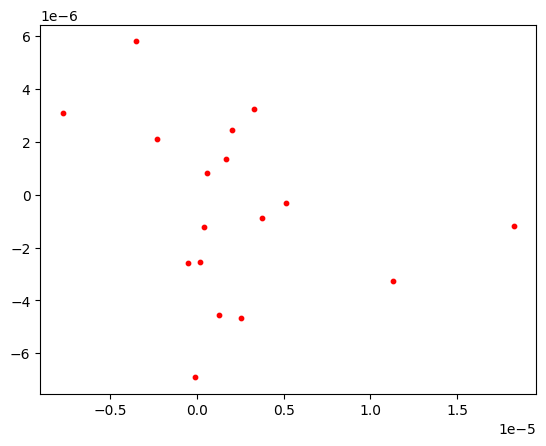

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize the 2D pose on an image
def visualize_pose(keypoints_3d):
    """
    Visualize 2D pose on the given image.
    We assume the keypoints_3d has shape [17, 3] where 17 is the number of keypoints
    and 3 represents (x, y, z) coordinates.
    """

    # Plot keypoints (only x and y for 2D visualization)
    for joint in keypoints_3d:
        plt.scatter(joint[0], joint[1], s=10, color='r')  # Only plot x, y coordinates

    # Display the plot
    plt.show()

# Assuming you're using the same DataLoader as before
images, keypoints_3d = next(iter(dataloader))

# Make predictions on the batch of images
with torch.no_grad():
    outputs = model(images.to(device))

# Visualize the first image and its predicted 3D keypoints (2D visualization)
# Only use the first image in the batch and the last frame
visualize_pose(outputs[0].cpu())

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Mock dataset class
class PoseDataset(Dataset):
    def __init__(self, num_samples=100, num_frames=100, num_keypoints=17, input_dim=2, output_dim=3):
        self.keypoints_2d = torch.rand(num_samples, num_frames, num_keypoints, input_dim)
        self.keypoints_3d = torch.rand(num_samples, num_frames, num_keypoints, output_dim)

    def __len__(self):
        return self.keypoints_2d.shape[0]

    def __getitem__(self, idx):
        return self.keypoints_2d[idx], self.keypoints_3d[idx]

# Simple model for 3D pose estimation
class PoseEstimationModel(nn.Module):
    def __init__(self, num_keypoints=17, input_dim=2, output_dim=3):
        super(PoseEstimationModel, self).__init__()
        self.num_keypoints = num_keypoints
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.model = nn.Sequential(
            nn.Linear(num_keypoints * input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_keypoints * output_dim)
        )

    def forward(self, x):
        # Ensure the input shape is (batch_size, num_keypoints, input_dim)
        if len(x.shape) == 3 and x.shape[1:] == (self.num_keypoints, self.input_dim):
            batch_size, num_keypoints, input_dim = x.size()
        else:
            raise ValueError(f"Expected input shape (batch_size, num_keypoints, input_dim), but got {x.shape}")

        x = x.view(batch_size, -1)  # Flatten input
        x = self.model(x)
        x = x.view(batch_size, self.num_keypoints, self.output_dim)  # Reshape to (batch_size, num_keypoints, output_dim)
        return x

# Instantiate dataset, dataloader, and model
dataset = PoseDataset(num_samples=16, num_frames=6344, num_keypoints=17)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

model = PoseEstimationModel(num_keypoints=17, input_dim=2, output_dim=3)

# Forward pass through the model
for keypoints_2d, keypoints_3d in dataloader:
    # Reshape to flatten frames into the batch
    batch_size, num_frames, num_keypoints, input_dim = keypoints_2d.size()
    keypoints_2d = keypoints_2d.view(-1, num_keypoints, input_dim)  # (batch_size * num_frames, 17, 2)
    keypoints_3d = keypoints_3d.view(-1, num_keypoints, keypoints_3d.size(-1))  # (batch_size * num_frames, 17, 3)

    # Forward pass
    predicted_3d = model(keypoints_2d.float())
    print(f"Predicted 3D Shape: {predicted_3d.shape}")
    print(f"Ground Truth 3D Shape: {keypoints_3d.shape}")
    break  # Process one batch for testing


Predicted 3D Shape: torch.Size([6344, 17, 3])
Ground Truth 3D Shape: torch.Size([6344, 17, 3])


Epoch 1, Loss: 0.33133333921432495
Epoch 2, Loss: 0.32284754514694214


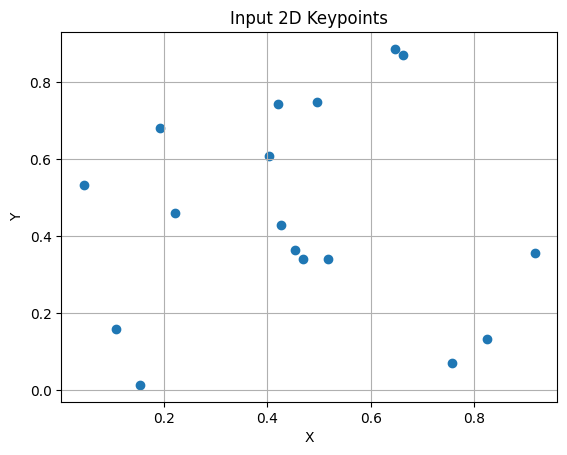

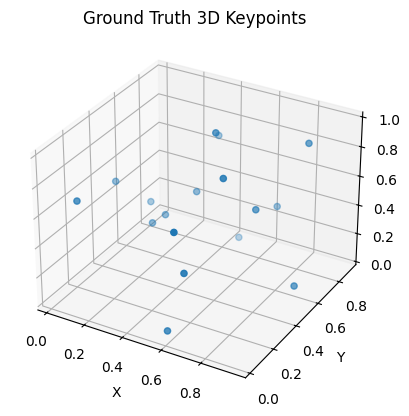

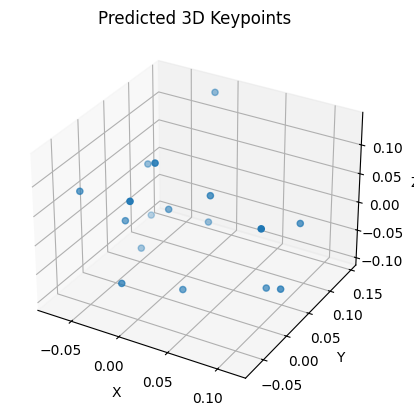

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# -----------------
# Sample Dataset
# -----------------
# Create dummy data (replace with your actual data)
batch_size = 16
num_keypoints = 17
keypoints_2d = torch.rand((batch_size, num_keypoints, 2))  # 2D keypoints
keypoints_3d = torch.rand((batch_size, num_keypoints, 3))  # 3D ground truth keypoints
dataset = TensorDataset(keypoints_2d, keypoints_3d)
dataloader = DataLoader(dataset, batch_size=batch_size)

# -----------------
# Model Definition
# -----------------
class HourglassTokenizerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HourglassTokenizerModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim * num_keypoints, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_keypoints),
        )

    def forward(self, x):
        if len(x.shape) != 3 or x.shape[2] != 2:
            raise ValueError(f"Expected input shape (batch_size, num_keypoints, input_dim), but got {x.shape}")

        batch_size, num_keypoints, input_dim = x.size()
        x = x.view(batch_size, -1)  # Flatten input
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(batch_size, num_keypoints, -1)  # Reshape to (batch_size, num_keypoints, output_dim)
        return x

# -----------------
# Visualization Functions
# -----------------
def plot_keypoints_2d(keypoints_2d, title="2D Keypoints"):
    plt.scatter(keypoints_2d[:, 0], keypoints_2d[:, 1])
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.show()

def plot_keypoints_3d(keypoints_3d, title="3D Keypoints"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(keypoints_3d[:, 0], keypoints_3d[:, 1], keypoints_3d[:, 2])
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# -----------------
# Training and Visualization
# -----------------
# Model Initialization
input_dim = 2
hidden_dim = 128
output_dim = 3
model = HourglassTokenizerModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(2):  # Train for 2 epochs
    for keypoints_2d_batch, keypoints_3d_batch in dataloader:
        optimizer.zero_grad()
        predicted_3d = model(keypoints_2d_batch.float())
        loss = criterion(predicted_3d, keypoints_3d_batch.float())
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# -----------------
# Intermediate Visualization
# -----------------
# Extract one sample and visualize
sample_2d, sample_3d = next(iter(dataloader))
predicted_3d = model(sample_2d.float()).detach()

# Plot the first sample's 2D keypoints
plot_keypoints_2d(sample_2d[0].numpy(), title="Input 2D Keypoints")

# Plot the first sample's ground truth 3D keypoints
plot_keypoints_3d(sample_3d[0].numpy(), title="Ground Truth 3D Keypoints")

# Plot the first sample's predicted 3D keypoints
plot_keypoints_3d(predicted_3d[0].numpy(), title="Predicted 3D Keypoints")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# -----------------
# Sample Dataset (using random data for illustration)
# -----------------
batch_size = 16
num_keypoints = 17
keypoints_2d = torch.rand((batch_size, num_keypoints, 2))  # 2D keypoints
keypoints_3d = torch.rand((batch_size, num_keypoints, 3))  # 3D ground truth keypoints
dataset = TensorDataset(keypoints_2d, keypoints_3d)
dataloader = DataLoader(dataset, batch_size=batch_size)

# -----------------
# HOT Model Definition (using Hourglass and Transformer)
# -----------------
class HourglassTokenizerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_keypoints, num_heads, num_layers):
        super(HourglassTokenizerModel, self).__init__()

        # Define layers as before (downsampling and upsampling)
        self.down_conv = nn.Conv2d(input_dim, hidden_dim, kernel_size=3, stride=2, padding=1)
        self.up_conv = nn.ConvTranspose2d(hidden_dim, input_dim, kernel_size=3, stride=2, padding=1)

        self.encoder = TransformerEncoder(input_dim, hidden_dim, num_heads, num_layers)
        self.decoder = nn.Linear(hidden_dim, output_dim * num_keypoints)

    def forward(self, x):
        # Ensure correct input shape (batch_size, num_keypoints, input_dim)
        batch_size, num_keypoints, input_dim = x.size()

        # Reshape the input to fit the model architecture
        x = x.view(batch_size, input_dim, num_keypoints, 1)  # (batch_size, input_dim, num_keypoints, 1)

        # Apply the downsampling and upsampling layers
        downsampled = self.relu(self.down_conv(x))
        upsampled = self.relu(self.up_conv(downsampled))

        # Ensure the dimensions match for addition
        upsampled = upsampled.view(batch_size, num_keypoints, input_dim)  # Adjust back to original shape

        # Skip connection: add the input tensor back after upsampling
        return upsampled + x  # Ensure dimensions are aligned


class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(TransformerEncoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

class HOTModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_keypoints, num_heads, num_layers):
        super(HOTModel, self).__init__()

        # Hourglass Block for Multi-scale feature extraction
        self.hourglass1 = HourglassBlock(input_dim, hidden_dim)
        self.hourglass2 = HourglassBlock(hidden_dim, output_dim)

        # Transformer Encoder for capturing keypoint relationships
        self.transformer = TransformerEncoder(embed_dim=output_dim, num_heads=num_heads, num_layers=num_layers)

        # Final linear layer to map the output to the required dimensions
        self.fc = nn.Linear(output_dim * num_keypoints, output_dim * num_keypoints)

    def forward(self, x):
        # Apply Hourglass Network
        x = x.permute(0, 2, 1)  # (batch_size, num_keypoints, input_dim) -> (batch_size, input_dim, num_keypoints)
        x = self.hourglass1(x)
        x = self.hourglass2(x)

        # Transformer to capture relationships between keypoints
        x = x.permute(0, 2, 1)  # (batch_size, input_dim, num_keypoints) -> (batch_size, num_keypoints, input_dim)
        x = self.transformer(x)

        # Flatten for the final prediction
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        # Reshape back to (batch_size, num_keypoints, output_dim)
        x = x.view(x.size(0), num_keypoints, -1)
        return x

# -----------------
# Visualization Functions
# -----------------
def plot_keypoints_2d(keypoints_2d, title="2D Keypoints"):
    plt.scatter(keypoints_2d[:, 0], keypoints_2d[:, 1])
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.show()

def plot_keypoints_3d(keypoints_3d, title="3D Keypoints"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(keypoints_3d[:, 0], keypoints_3d[:, 1], keypoints_3d[:, 2])
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# -----------------
# Training and Visualization
# -----------------
# Model Initialization
input_dim = 2
hidden_dim = 128

num_layers = 4
# Ensure output_dim is divisible by num_heads
num_heads = 4  # You can adjust this as needed
output_dim = 12  # Ensure this is divisible by num_heads

# Reinitialize the model with corrected dimensions
model = HOTModel(input_dim, hidden_dim, output_dim, num_keypoints, num_heads, num_layers)

model = HOTModel(input_dim, hidden_dim, output_dim, num_keypoints, num_heads, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(2):  # Train for 2 epochs
    for keypoints_2d_batch, keypoints_3d_batch in dataloader:
        optimizer.zero_grad()
        predicted_3d = model(keypoints_2d_batch.float())
        loss = criterion(predicted_3d, keypoints_3d_batch.float())
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# -----------------
# Intermediate Visualization
# -----------------
# Extract one sample and visualize
sample_2d, sample_3d = next(iter(dataloader))
predicted_3d = model(sample_2d.float()).detach()

# Plot the first sample's 2D keypoints
plot_keypoints_2d(sample_2d[0].numpy(), title="Input 2D Keypoints")

# Plot the first sample's ground truth 3D keypoints
plot_keypoints_3d(sample_3d[0].numpy(), title="Ground Truth 3D Keypoints")

# Plot the first sample's predicted 3D keypoints
plot_keypoints_3d(predicted_3d[0].numpy(), title="Predicted 3D Keypoints")


TypeError: HourglassBlock.__init__() takes 2 positional arguments but 3 were given

Saving human_body.jpg to human_body.jpg
Detected 2D Keypoints from human_body.jpg: (33, 2)


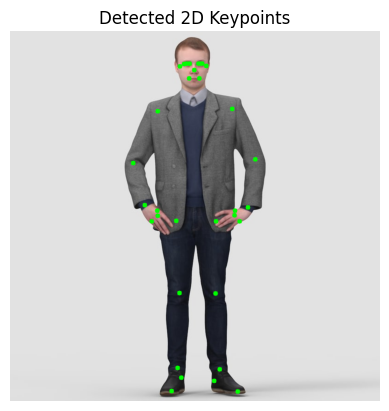

Predicted 3D Keypoints Shape: torch.Size([1, 33, 3])


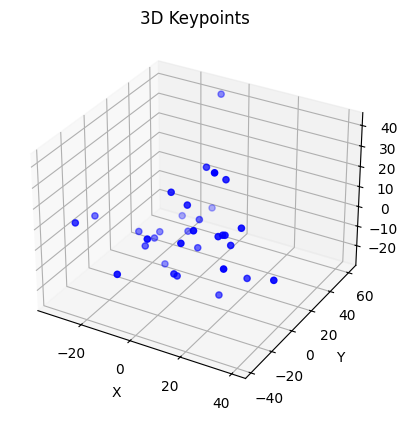

In [ ]:

!pip install mediapipe
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mediapipe import solutions
from google.colab import files


from PIL import Image

# -----------------
# Upload Image
# -----------------
def upload_image():
    uploaded = files.upload()  # Upload an image
    for filename in uploaded.keys():
        image = cv2.imread(filename)  # Read the image using OpenCV
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        return filename, image, image_rgb

def plot_image_with_keypoints(image, keypoints_2d):
    for x, y in keypoints_2d:
        cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected 2D Keypoints")
    plt.show()

# -----------------
# Extract 2D Keypoints Using MediaPipe
# -----------------
def extract_keypoints(image_rgb):
    with solutions.pose.Pose(static_image_mode=True) as pose:
        results = pose.process(image_rgb)
        if results.pose_landmarks:
            keypoints = [
                (lm.x * image_rgb.shape[1], lm.y * image_rgb.shape[0])
                for lm in results.pose_landmarks.landmark
            ]
            return np.array(keypoints)
        else:
            return None

# -----------------
# Model Definition for 2D-to-3D Conversion
# -----------------
class HourglassTokenizerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_keypoints):
        super(HourglassTokenizerModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim * num_keypoints, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_keypoints),
        )

    def forward(self, x):
        if len(x.shape) != 3 or x.shape[2] != 2:
            raise ValueError(f"Expected input shape (batch_size, num_keypoints, input_dim), but got {x.shape}")

        batch_size, num_keypoints, input_dim = x.size()
        x = x.view(batch_size, -1)  # Flatten input
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(batch_size, num_keypoints, -1)  # Reshape to (batch_size, num_keypoints, output_dim)
        return x

# -----------------
# Main Code for Upload and Keypoint Extraction
# -----------------
filename, image_bgr, image_rgb = upload_image()
keypoints_2d = extract_keypoints(image_rgb)

if keypoints_2d is not None:
    print(f"Detected 2D Keypoints from {filename}: {keypoints_2d.shape}")
    plot_image_with_keypoints(image_bgr, keypoints_2d)
else:
    print("No keypoints detected in the uploaded image!")

# -----------------
# Convert 2D to 3D Keypoints
# -----------------
if keypoints_2d is not None:
    num_keypoints = keypoints_2d.shape[0]
    keypoints_2d_tensor = torch.tensor(keypoints_2d).unsqueeze(0).float()  # Add batch dimension

    # Define Model
    input_dim = 2
    hidden_dim = 128
    output_dim = 3
    model = HourglassTokenizerModel(input_dim, hidden_dim, output_dim, num_keypoints)

    # Predict 3D Keypoints
    predicted_3d = model(keypoints_2d_tensor)
    print("Predicted 3D Keypoints Shape:", predicted_3d.shape)

    # Visualize 3D Keypoints
    def plot_keypoints_3d(keypoints_3d):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(
            keypoints_3d[:, 0], keypoints_3d[:, 1], keypoints_3d[:, 2], c='b', marker='o'
        )
        ax.set_title("3D Keypoints")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()

    plot_keypoints_3d(predicted_3d[0].detach().numpy())
else:
    print("Skipping 3D keypoints prediction due to missing 2D keypoints.")


3D Pose Estimation using HOT

Saving human_body.jpg to human_body (1).jpg


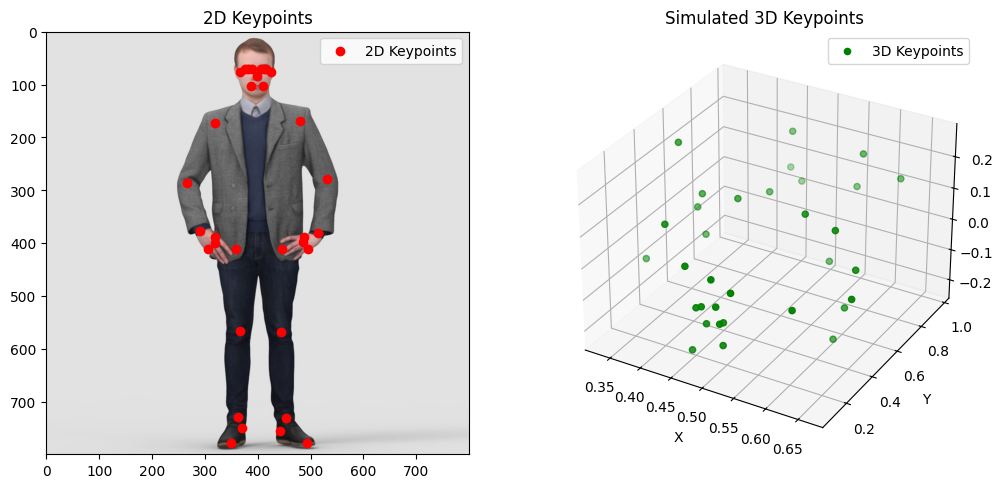

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab import files
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to extract 2D keypoints using MediaPipe
def extract_2d_keypoints(image):
    mp_pose = mp.solutions.pose
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        # Convert the image to RGB (required by MediaPipe)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            keypoints = []
            for landmark in results.pose_landmarks.landmark:
                keypoints.append([landmark.x, landmark.y])
            return np.array(keypoints)
        else:
            return None

# Function to simulate 3D pose estimation
def simulate_3d_pose(keypoints_2d):
    # Simulate 3D keypoints by adding small random noise to the 2D keypoints
    # This is just a placeholder. Replace with an actual 3D model for real results.
    noise = np.random.normal(0, 0.1, keypoints_2d.shape)
    keypoints_3d = np.hstack([keypoints_2d, noise])  # Adding Z-axis as random noise
    return keypoints_3d

# Function to visualize 2D and 3D keypoints
def visualize_2d_and_3d(image, keypoints_2d, keypoints_3d):
    fig = plt.figure(figsize=(12, 6))

    # Plot 2D Keypoints
    ax1 = fig.add_subplot(121)
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.scatter(keypoints_2d[:, 0] * image.shape[1], keypoints_2d[:, 1] * image.shape[0], c='r', label='2D Keypoints')
    ax1.legend()
    ax1.set_title("2D Keypoints")

    # Plot 3D Keypoints
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(keypoints_3d[:, 0], keypoints_3d[:, 1], keypoints_3d[:, 2], c='g', label='3D Keypoints')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.legend()
    ax2.set_title("Simulated 3D Keypoints")

    plt.show()

# Main function to upload an image and estimate pose
def main():
    # Upload the image file
    uploaded = files.upload()
    image_path = next(iter(uploaded.keys()))  # Get the image path

    # Read the uploaded image
    image = cv2.imread(image_path)

    # Extract 2D keypoints
    keypoints_2d = extract_2d_keypoints(image)

    if keypoints_2d is not None:
        # Simulate 3D keypoints
        keypoints_3d = simulate_3d_pose(keypoints_2d)

        # Visualize the 2D and simulated 3D keypoints
        visualize_2d_and_3d(image, keypoints_2d, keypoints_3d)
    else:
        print("No keypoints detected in the image.")

# Run the main function
if __name__ == "__main__":
    main()


Saving human_body.jpg to human_body (6).jpg
Detected 2D Keypoints from human_body (6).jpg: (33, 2)


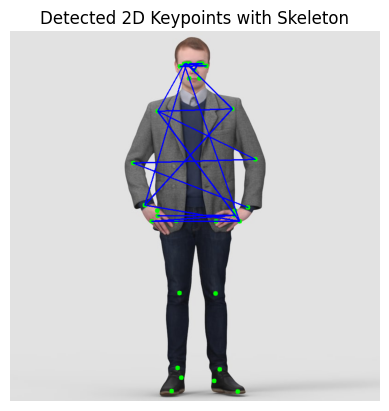

Predicted 3D Keypoints Shape: torch.Size([1, 33, 3])


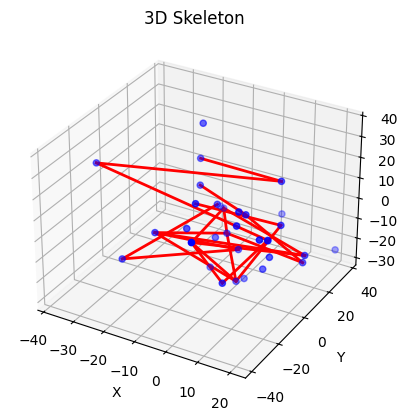

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mediapipe import solutions
from google.colab import files

# -----------------
# Upload Image
# -----------------
def upload_image():
    uploaded = files.upload()  # Upload an image
    for filename in uploaded.keys():
        image = cv2.imread(filename)  # Read the image using OpenCV
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        return filename, image, image_rgb

# -----------------
# Skeleton Connections (MediaPipe Pose Keypoints)
# -----------------
# MediaPipe Pose Keypoints Indices (33 keypoints)
# These are predefined in the MediaPipe model
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Head to shoulders to elbows to wrists
    (0, 5), (5, 6), (6, 7), (7, 8),  # Head to hips to knees to ankles
    (11, 12), (12, 13), (13, 14), (14, 15), # Right arm
    (16, 17), (17, 18), (18, 19), (19, 20), # Left arm
    (5, 11), (6, 12), # Hips to shoulders
    (5, 16), (6, 17), # Left hip to left knee, right hip to right knee
    (11, 16), (12, 17), # Right shoulder to right hip, left shoulder to left hip
]

# -----------------
# Plot Image with 2D Keypoints and Skeleton
# -----------------
def plot_image_with_keypoints(image, keypoints_2d, connections=None):
    for x, y in keypoints_2d:
        cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
    if connections:
        for start, end in connections:
            x_start, y_start = keypoints_2d[start]
            x_end, y_end = keypoints_2d[end]
            cv2.line(image, (int(x_start), int(y_start)), (int(x_end), int(y_end)), (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected 2D Keypoints with Skeleton")
    plt.show()

# -----------------
# Extract 2D Keypoints Using MediaPipe
# -----------------
def extract_keypoints(image_rgb):
    with solutions.pose.Pose(static_image_mode=True) as pose:
        results = pose.process(image_rgb)
        if results.pose_landmarks:
            keypoints = [
                (lm.x * image_rgb.shape[1], lm.y * image_rgb.shape[0])
                for lm in results.pose_landmarks.landmark
            ]
            return np.array(keypoints)
        else:
            return None

# -----------------
# Model Definition for 2D-to-3D Conversion
# -----------------
class HourglassTokenizerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_keypoints):
        super(HourglassTokenizerModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim * num_keypoints, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim * num_keypoints),
        )

    def forward(self, x):
        if len(x.shape) != 3 or x.shape[2] != 2:
            raise ValueError(f"Expected input shape (batch_size, num_keypoints, input_dim), but got {x.shape}")

        batch_size, num_keypoints, input_dim = x.size()
        x = x.view(batch_size, -1)  # Flatten input
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(batch_size, num_keypoints, -1)  # Reshape to (batch_size, num_keypoints, output_dim)
        return x

# -----------------
# Main Code for Upload and Keypoint Extraction
# -----------------
filename, image_bgr, image_rgb = upload_image()
keypoints_2d = extract_keypoints(image_rgb)

if keypoints_2d is not None:
    print(f"Detected 2D Keypoints from {filename}: {keypoints_2d.shape}")
    plot_image_with_keypoints(image_bgr, keypoints_2d, connections)
else:
    print("No keypoints detected in the uploaded image!")

# -----------------
# Convert 2D to 3D Keypoints
# -----------------
if keypoints_2d is not None:
    num_keypoints = keypoints_2d.shape[0]
    keypoints_2d_tensor = torch.tensor(keypoints_2d).unsqueeze(0).float()  # Add batch dimension

    # Define Model
    input_dim = 2
    hidden_dim = 128
    output_dim = 3
    model = HourglassTokenizerModel(input_dim, hidden_dim, output_dim, num_keypoints)

    # Predict 3D Keypoints
    predicted_3d = model(keypoints_2d_tensor)
    print("Predicted 3D Keypoints Shape:", predicted_3d.shape)

    # Visualize 3D Keypoints as Skeleton
    def plot_keypoints_3d_skeleton(keypoints_3d, connections):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(
            keypoints_3d[:, 0], keypoints_3d[:, 1], keypoints_3d[:, 2], c='b', marker='o'
        )

        # Plot the skeleton connections in 3D
        for start, end in connections:
            ax.plot(
                [keypoints_3d[start, 0], keypoints_3d[end, 0]],
                [keypoints_3d[start, 1], keypoints_3d[end, 1]],
                [keypoints_3d[start, 2], keypoints_3d[end, 2]], c='r', linewidth=2
            )

        ax.set_title("3D Skeleton")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()

    plot_keypoints_3d_skeleton(predicted_3d[0].detach().numpy(), connections)
else:
    print("Skipping 3D keypoints prediction due to missing 2D keypoints.")
